# 2. Simulators

Author : [Gwonhak Lee](https://github.com/snow0369) (gwonhak@gmail.com)

-----
 [Qiskit Aer](https://github.com/Qiskit/qiskit-aer)에서는 양자회로의 CPU (또는 GPU) 기반 시뮬레이션 backend를 제공합니다.
 [앞선 튜토리얼](./1_hello_qiskit.ipynb)에서는 backend 중 하나인 qasm_simulator를 활용하였고, 대표적으로 Aer에서 제공하는
 Simulation Backend는 다음과 같습니다.

| 이름    | 설명    | 결과    |
|-------------|-------------|-------------|
| qasm_simulator | 이상적이거나 노이즈가 있는 양자 프로세서를 emulation하여 **measurement count** 를 반환합니다. | Counts |
| statevector_simulator | 이상적인 시뮬레이션을 수행하여 **최종 양자상태**를 반환합니다. | Final state (Vector) |
| unitary_simulator | 이상적인 양자회로의 최종 **Unitary Matrix** 를 반환합니다. | Unitary Matrix |

([GPU 기반 Aer](https://github.com/Qiskit/qiskit-aer#installing-gpu-support)는 Linux 운영체제에서만 가능하므로 본 튜토리얼에서는
포함하지 않습니다.)

### 0. 필요한 요소 불러오기

In [22]:
import numpy as np

from qiskit.providers.aer import AerProvider
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.tools.visualization import plot_histogram
import qiskit.providers.aer.noise as noise
from qiskit.quantum_info import hellinger_fidelity

### 1-1. Ideal QASM Simulation

qasm simulator는 양자 프로세서를 emulation하여 measurement count를 반환합니다.
주어진 실험 횟수(shots)에 대해 결과의 빈도수를 확인할 수 있습니다.

이번 실험에서는 3개의 qubit에 대해 다음과 같은 연산을 수행하는 회로를 구현하였습니다.

$ U(\tau) = \exp{(-i\tau \hat{X}_1 \hat{X}_2 \hat{X}_3)} $

**Binding Parameters**

다음과 같이 파라미터 Tau를 선언하고, 이를 회로에 적용시킨 뒤 시뮬레이션 단계에서 tau에 적당한 값을 지정할 수 있습니다.

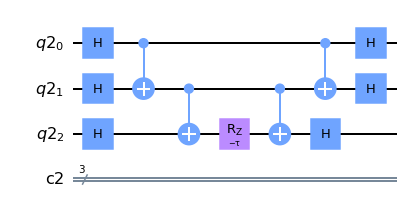

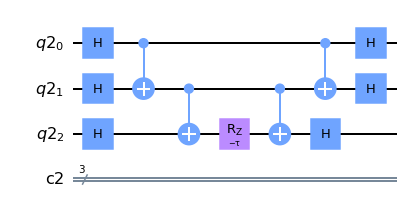

In [23]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

tau = Parameter('τ')

qc.h(qr)
qc.cx(qr[0], qr[1])
qc.cx(qr[1], qr[2])

qc.rz(-1 * tau, qr[2])

qc.cx(qr[1], qr[2])
qc.cx(qr[0], qr[1])
qc.h(qr)
qc.draw('mpl')


다음과 같이 `compose` method를 통해 측정 회로`meas`를 따로 정의하고, 앞서 정의한 회로 `qc`와 병합한 회로 `qasm_qc`를 생성 할 수 있습니다.

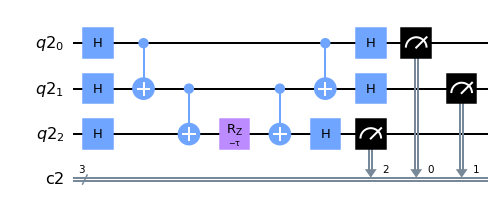

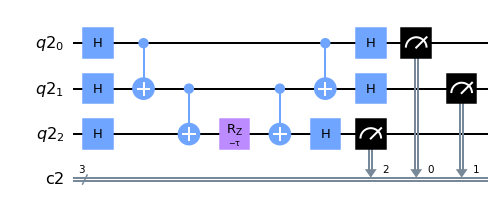

In [24]:
meas = QuantumCircuit(qr, cr)
meas.measure(qr, cr)

qasm_qc = qc.compose(meas)
qasm_qc.draw('mpl')

이제 tau에 `pi/4`를 대입한 뒤 qasm simulation을 수행합니다.

{'111': 618, '000': 3478}


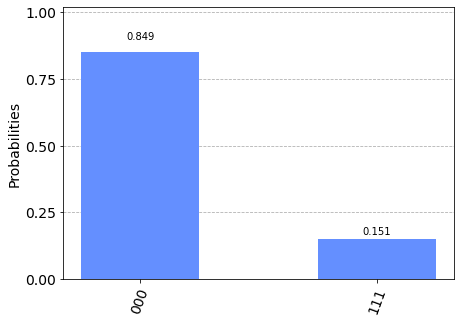

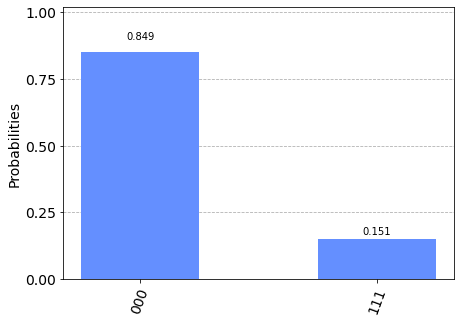

In [25]:
bind_qasm_qc = qasm_qc.bind_parameters({tau: np.pi/4})
qasm_backend = AerProvider().get_backend('qasm_simulator')
job_qasm = qasm_backend.run(bind_qasm_qc, shots=4096)
counts_qasm = job_qasm.result().get_counts()
print(counts_qasm)
plot_histogram(counts_qasm)

### 1-2. Noisy QASM Simulation

다음으로, QASM Simulation에 depolarization error를 추가하는 간단한 예시를 살펴보겠습니다.

**Depolarization Error**

$ E(ρ) = (1 - λ) ρ + λ \text{Tr}[ρ] \frac{I}{2^n} $
* If λ = 0 this is the identity channel. E(ρ) = ρ
* If λ = 1 this is a completely depolarizing channel. E(ρ) = I / 2 <sup> n </sup>
* If λ = 4^n / (4^n - 1) this is a uniform Pauli error channel:

    $E(ρ) = \sum_j P_j ρ P_j / (4^n - 1) \text{ for all } P_j \neq I.$

In [26]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['h', 'rz'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

생성한 노이즈모델과 함께 qasm simulation을 수행합니다.

{'101': 6, '010': 28, '111': 592, '000': 3366, '011': 48, '001': 24, '110': 5, '100': 27}


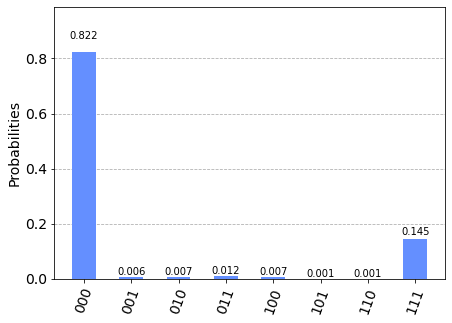

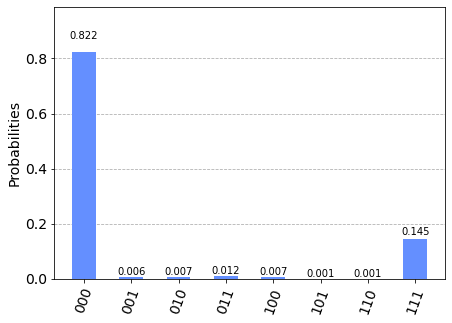

In [27]:
job_qasm_noisy = qasm_backend.run(bind_qasm_qc, shots=4096, noise_model=noise_model)
counts_qasm_noisy = job_qasm_noisy.result().get_counts()
print(counts_qasm_noisy)
plot_histogram(counts_qasm_noisy)

Depolarization noise model을 적용하였을때 Ideal한 case에서 관측되지 않는 결과들과 함께 오차가 발생했음을 확인할 수 있습니다.

Ideal case와 비교하기 위해 fidelity를 계산합니다.

In [28]:
print(hellinger_fidelity(counts_qasm, counts_qasm_noisy))

0.9663053540592


### 2. Statevector Simulation

다음으로, 최종 양자상태를 확인할 수 있는 statevector simulation을 수행합니다.

* statevector simulation을 수행하는 회로에는 측정 gate를 배제한 다음 회로를 사용합니다.

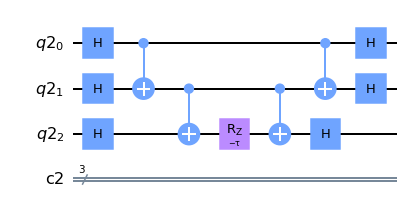

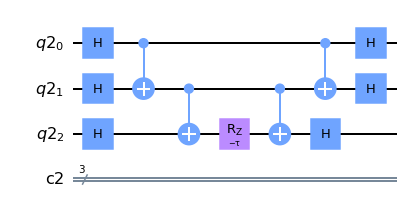

In [29]:
qc.draw('mpl')

In [30]:
bind_qc = qc.bind_parameters({tau: np.pi/4})
sv_backend = AerProvider().get_backend('statevector_simulator')
job_sv = sv_backend.run(bind_qc)
final_sv = job_sv.result().get_statevector()
print(final_sv)

[ 9.23879533e-01-1.85405734e-16j  7.28581877e-18+5.31300993e-17j
  1.04452190e-17+6.75749095e-17j -2.10515501e-17+3.99094222e-17j
  2.11636066e-17+6.75749095e-17j -2.10515501e-17+7.49015826e-17j
 -1.62588398e-17+6.24097619e-17j  5.64200183e-17+3.82683432e-01j]


양자상태가 numpy vector 형태로 주어진 것을 확인할 수 있습니다.

### 2. Statevector Simulation

다음으로, 회로의 unitary 행렬을 확인할 수 있는 unitary simulation을 수행합니다.

* unitary simulation을 수행하는 회로에는 측정 gate를 배제한 회로를 사용합니다.


In [31]:
unitary_backend = AerProvider().get_backend('unitary_simulator')
job_unitary = unitary_backend.run(bind_qc)
unitary = job_unitary.result().get_unitary()
print(unitary)

[[ 9.23879533e-01-1.85405734e-16j  1.31001018e-18+5.31300993e-17j
  -2.92693464e-19+6.06360156e-17j -2.58136540e-17+7.91617336e-17j
   1.51877980e-17+6.06360156e-17j -2.58136540e-17+6.34048468e-17j
  -1.14967359e-17+6.24097619e-17j  2.32069156e-16+3.82683432e-01j]
 [ 7.28581877e-18+5.31300993e-17j  9.23879533e-01-2.42600543e-16j
  -2.58136540e-17+7.91617336e-17j -2.92693464e-19+5.08229377e-17j
  -2.58136540e-17+4.95270590e-17j  1.51877980e-17+5.08229377e-17j
   2.45946944e-16+3.82683432e-01j -1.14967359e-17-5.95219354e-17j]
 [ 1.04452190e-17+6.75749095e-17j -2.10515501e-17+3.99094222e-17j
   9.23879533e-01-2.39726359e-16j  1.31001018e-18+3.92523115e-17j
   1.62588398e-17+5.54708680e-17j  2.18191368e-16+3.82683432e-01j
   1.51877980e-17+4.55677018e-17j -1.19358662e-17-6.71494024e-17j]
 [-2.10515501e-17+3.99094222e-17j  1.04452190e-17+4.38840438e-17j
   7.28581877e-18+1.96261557e-17j  9.23879533e-01-4.11310787e-16j
   8.41755939e-17+3.82683432e-01j  1.62588398e-17-5.95219354e-17j
  -2.58

In [32]:
for idx, x in np.ndenumerate(unitary):
    if abs(x) > 1e-7:
        print(f"{idx}, {x.real if abs(x.real) > 1e-7 else 0.0} {' + j'+ str(x.imag) if abs(x.imag) > 1e-7 else 0.0}")

(0, 0), 0.9238795325112867 0.0
(0, 7), 0.0  + j0.3826834323650897
(1, 1), 0.9238795325112867 0.0
(1, 6), 0.0  + j0.3826834323650897
(2, 2), 0.9238795325112867 0.0
(2, 5), 0.0  + j0.3826834323650897
(3, 3), 0.9238795325112867 0.0
(3, 4), 0.0  + j0.3826834323650897
(4, 3), 0.0  + j0.3826834323650898
(4, 4), 0.9238795325112867 0.0
(5, 2), 0.0  + j0.3826834323650898
(5, 5), 0.9238795325112867 0.0
(6, 1), 0.0  + j0.3826834323650898
(6, 6), 0.9238795325112867 0.0
(7, 0), 0.0  + j0.3826834323650898
(7, 7), 0.9238795325112867 0.0
